In [1]:
# in this series, we are going to build together a quant trading strategy from scratch. 

In [2]:
# lots of feedback that you would like a pratical version of my intro to quant trading video

In [3]:
# code available on github, read the readme and install the libraries

In [4]:
# 3 videos
# y_hat = model(x)
# orders = strategy(y_hat)
# execute(orders)

In [5]:
# Want part two? Please like and subscribe to let me know! And please leave a comment


In [6]:
# build a regression model to predict BTCUSD -> future log return 


# why BTCUSDT -logistic reason (Public API,Orderbook,DMA)
# clone and experiment - this is just a foundation to build upon



In [7]:
# it doesn't matter what exactly we we are trading here
# what i teach in this video is the technical and research methodology needed to build your own model for any asset
# so dont it's just only applicable for BTCUSDT

In [8]:
# this is just a foundation to build upon

In [9]:
# assumes level of programming experience
# don't worry if you don't need have programming experience
# making a machine learning series where you learn python and  machine learning at the same time.


# import all libs

In [10]:
# Data and analysis libraries
import polars as pl                         # Fast dataframes for financial data
import numpy as np                          # Numerical computing library
from datetime import datetime, timedelta    # Date and time operations
import random


# Machine learning libraries  
import torch                                # PyTorch framework
import torch.nn as nn                       # Neural network modules
import torch.optim as optim                 # Optimization algorithms
import research                             # Model building and training utilities


# Visualization and 
import altair as alt                        # Interactive visualization library

# data sources
import binance                              # Binance market data utilities


In [11]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

In [12]:
pl.Config.set_tbl_width_chars(200)
pl.Config.set_fmt_str_lengths(100)
pl.Config.set_tbl_cols(-1)  # Show all columns

polars.config.Config

# Research Parameters

In [13]:
# Trading pair symbol
sym = 'BTCUSDT'
# Historical data window in days (e.g., 6 months)            
hist_data_window = 7 * 4 * 6
# time horizon of time series (time interval)
time_interval = '1h'
# Max number of auto-regressive lags
max_lags = 4
# Forecast horizon in steps 
forecast_horizon = 1
# Sharpe annualized rate (so it's independent of time frequency)
annualized_rate = research.sharpe_annualization_factor(time_interval, 365, 24)


# download trade feeds

## Explain columns

In [14]:
binance.download_trades(sym, hist_data_window)


In [15]:
ts = research.load_ohlc_timeseries(sym,  time_interval)
ts

Loading BTCUSDT: 100%|██████████| 169/169 [00:09<00:00, 18.71file/s]


datetime,open,high,low,close
datetime[μs],f64,f64,f64,f64
2025-04-23 00:00:00,93404.9,93864.9,92730.0,92858.2
2025-04-23 01:00:00,92858.2,93464.8,92552.0,92603.8
2025-04-23 02:00:00,92603.7,93232.5,92570.0,92830.0
2025-04-23 03:00:00,92830.0,93178.4,92650.0,93126.0
2025-04-23 04:00:00,93126.0,93638.2,92964.1,93606.1
…,…,…,…,…
2025-10-08 19:00:00,123389.8,123690.0,123095.0,123381.8
2025-10-08 20:00:00,123381.8,123671.5,122757.5,122784.6
2025-10-08 21:00:00,122784.6,123272.2,122739.7,123231.4


# Create Time Series

### Aggregate data into a regular time series

In [16]:
research.load_timeseries(sym, time_interval, pl.col('price').quantile(0.5).alias('price_median'))

Loading BTCUSDT: 100%|██████████| 169/169 [00:09<00:00, 18.59file/s]


datetime,price_median
datetime[μs],f64
2025-04-23 00:00:00,93351.6
2025-04-23 01:00:00,93053.7
2025-04-23 02:00:00,92860.0
2025-04-23 03:00:00,92865.3
2025-04-23 04:00:00,93194.6
…,…
2025-10-08 19:00:00,123402.0
2025-10-08 20:00:00,123340.0
2025-10-08 21:00:00,123098.6


# show static plot of time series

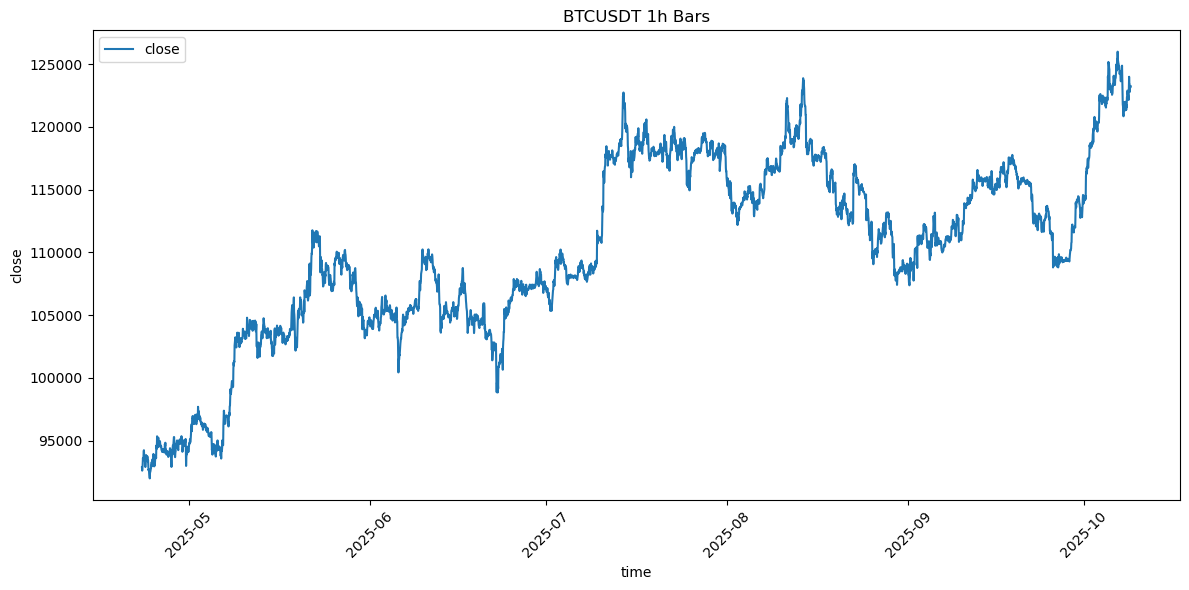

In [17]:
research.plot_static_timeseries(ts, sym, 'close', time_interval)

# dynamic interactive plot of time series

In [18]:

alt.data_transformers.enable("vegafusion")
research.plot_dyn_timeseries(ts, sym, 'close', time_interval)

alt.Chart(...)

# Feature Engineering

## Create Target - Log Return

In [19]:
price_time_series = pl.DataFrame({'price':[100.0,120.0,100.0]})
research.plot_column(price_time_series, 'price')

alt.Chart(...)

In [20]:
price_time_series = price_time_series.with_columns([
    pl.col('price').diff().alias('price_delta'),
    ((pl.col('price')-pl.col('price').shift())/pl.col('price').shift()).alias('price_return'),
    ((pl.col('price')/pl.col('price').shift())).log().alias('price_log_return'),
])
price_time_series

price,price_delta,price_return,price_log_return
f64,f64,f64,f64
100.0,null,null,null
120.0,20.0,0.2,0.182322
100.0,-20.0,-0.166667,-0.182322


## Create features and lagged features

In [21]:
ts = ts.with_columns(
    (pl.col('close') / pl.col('close').shift(forecast_horizon)).log().alias('close_log_return')
)

In [22]:
target = 'close_log_return'
lr = pl.col('close_log_return')
ts = ts.with_columns(
    lr.shift(forecast_horizon * 1).alias('close_log_return_lag_1'),
    lr.shift(forecast_horizon * 2).alias('close_log_return_lag_2'),
    lr.shift(forecast_horizon * 3).alias('close_log_return_lag_3'),
    lr.shift(forecast_horizon * 4).alias('close_log_return_lag_4'),
)
ts.select(['datetime','close_log_return','close_log_return_lag_1','close_log_return_lag_2','close_log_return_lag_3','close_log_return_lag_4'])

datetime,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64
2025-04-23 00:00:00,null,null,null,null,null
2025-04-23 01:00:00,-0.002743,null,null,null,null
2025-04-23 02:00:00,0.00244,-0.002743,null,null,null
2025-04-23 03:00:00,0.003184,0.00244,-0.002743,null,null
2025-04-23 04:00:00,0.005142,0.003184,0.00244,-0.002743,null
…,…,…,…,…,…
2025-10-08 19:00:00,-0.000065,-0.004816,0.007981,0.007015,-0.00105
2025-10-08 20:00:00,-0.004852,-0.000065,-0.004816,0.007981,0.007015
2025-10-08 21:00:00,0.003632,-0.004852,-0.000065,-0.004816,0.007981


In [23]:
ts = research.add_lags(ts, 'close_log_return', max_lags, forecast_horizon)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-04-23 00:00:00,93404.9,93864.9,92730.0,92858.2,null,null,null,null,null
2025-04-23 01:00:00,92858.2,93464.8,92552.0,92603.8,-0.002743,null,null,null,null
2025-04-23 02:00:00,92603.7,93232.5,92570.0,92830.0,0.00244,-0.002743,null,null,null
2025-04-23 03:00:00,92830.0,93178.4,92650.0,93126.0,0.003184,0.00244,-0.002743,null,null
2025-04-23 04:00:00,93126.0,93638.2,92964.1,93606.1,0.005142,0.003184,0.00244,-0.002743,null
…,…,…,…,…,…,…,…,…,…
2025-10-08 19:00:00,123389.8,123690.0,123095.0,123381.8,-0.000065,-0.004816,0.007981,0.007015,-0.00105
2025-10-08 20:00:00,123381.8,123671.5,122757.5,122784.6,-0.004852,-0.000065,-0.004816,0.007981,0.007015
2025-10-08 21:00:00,122784.6,123272.2,122739.7,123231.4,0.003632,-0.004852,-0.000065,-0.004816,0.007981


In [24]:
ts.drop_nulls()

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-04-23 05:00:00,93606.2,93606.2,93236.7,93441.6,-0.001759,0.005142,0.003184,0.00244,-0.002743
2025-04-23 06:00:00,93441.6,93845.1,93374.6,93582.5,0.001507,-0.001759,0.005142,0.003184,0.00244
2025-04-23 07:00:00,93582.6,94263.0,93443.3,94102.5,0.005541,0.001507,-0.001759,0.005142,0.003184
2025-04-23 08:00:00,94102.6,94453.0,93864.5,94228.6,0.001339,0.005541,0.001507,-0.001759,0.005142
2025-04-23 09:00:00,94228.5,94350.0,93850.0,93850.1,-0.004025,0.001339,0.005541,0.001507,-0.001759
…,…,…,…,…,…,…,…,…,…
2025-10-08 19:00:00,123389.8,123690.0,123095.0,123381.8,-0.000065,-0.004816,0.007981,0.007015,-0.00105
2025-10-08 20:00:00,123381.8,123671.5,122757.5,122784.6,-0.004852,-0.000065,-0.004816,0.007981,0.007015
2025-10-08 21:00:00,122784.6,123272.2,122739.7,123231.4,0.003632,-0.004852,-0.000065,-0.004816,0.007981


In [25]:
research.plot_distribution(ts, 'close_log_return', no_bins = 100)

alt.Chart(...)

In [26]:
research.plot_distribution(ts, 'close', no_bins=100)

alt.Chart(...)

# Build Model

In [27]:
# Simple Linear Model
class LinearModel(nn.Module):
    def __init__(self, input_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_features, 1)  # Single output (return prediction)
    
    def forward(self, x):
        return self.linear(x)


## Complexity

In [28]:
# Create models for comparison
input_features = 1  # Example: using 2 lag features

linear_model = LinearModel(input_features)


# Print parameter counts
research.print_model_info(linear_model, "Linear Model")
# Show the dramatic difference in complexity
research.total_model_params(linear_model)


Linear Model

Architecture:
  LinearModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

Parameter Count:
  Total parameters:      2
  Trainable parameters:  2



2

In [29]:
# y = w * x + b

## Splitting data by time

In [30]:
ts = ts.drop_nulls()

In [31]:
# training params
features = ['close_log_return_lag_1']
target = 'close_log_return'
test_size = 0.25

In [32]:
len(ts)

4051

In [33]:
int(len(ts) * test_size)

1012

In [34]:
# Train/test timeseries split
split_idx = int(len(ts) * (1-test_size))
split_idx

3038

In [35]:
len(ts)

4051

In [36]:
ts_train, ts_test = ts[:split_idx], ts[split_idx:]

In [37]:
ts_train

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-04-23 05:00:00,93606.2,93606.2,93236.7,93441.6,-0.001759,0.005142,0.003184,0.00244,-0.002743
2025-04-23 06:00:00,93441.6,93845.1,93374.6,93582.5,0.001507,-0.001759,0.005142,0.003184,0.00244
2025-04-23 07:00:00,93582.6,94263.0,93443.3,94102.5,0.005541,0.001507,-0.001759,0.005142,0.003184
2025-04-23 08:00:00,94102.6,94453.0,93864.5,94228.6,0.001339,0.005541,0.001507,-0.001759,0.005142
2025-04-23 09:00:00,94228.5,94350.0,93850.0,93850.1,-0.004025,0.001339,0.005541,0.001507,-0.001759
…,…,…,…,…,…,…,…,…,…
2025-08-27 14:00:00,111434.4,112568.5,111211.1,111758.0,0.002901,0.00131,0.000158,0.003081,0.001485
2025-08-27 15:00:00,111757.9,112037.2,111455.7,111965.1,0.001851,0.002901,0.00131,0.000158,0.003081
2025-08-27 16:00:00,111965.0,112198.8,111489.8,112062.0,0.000865,0.001851,0.002901,0.00131,0.000158


In [38]:
ts_test

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-08-27 19:00:00,111890.4,112174.0,111502.0,112032.8,0.001273,-0.003532,0.001999,0.000865,0.001851
2025-08-27 20:00:00,112032.9,112368.6,110854.4,112363.1,0.002944,0.001273,-0.003532,0.001999,0.000865
2025-08-27 21:00:00,112363.2,112401.5,111322.7,111480.7,-0.007884,0.002944,0.001273,-0.003532,0.001999
2025-08-27 22:00:00,111480.7,111551.7,111003.3,111355.1,-0.001127,-0.007884,0.002944,0.001273,-0.003532
2025-08-27 23:00:00,111355.1,111491.2,111039.9,111194.9,-0.00144,-0.001127,-0.007884,0.002944,0.001273
…,…,…,…,…,…,…,…,…,…
2025-10-08 19:00:00,123389.8,123690.0,123095.0,123381.8,-0.000065,-0.004816,0.007981,0.007015,-0.00105
2025-10-08 20:00:00,123381.8,123671.5,122757.5,122784.6,-0.004852,-0.000065,-0.004816,0.007981,0.007015
2025-10-08 21:00:00,122784.6,123272.2,122739.7,123231.4,0.003632,-0.004852,-0.000065,-0.004816,0.007981


In [39]:
X_train = torch.tensor(ts_train[features].to_numpy(), dtype=torch.float32)
X_test = ts_test[features].to_torch().float()
y_train = torch.tensor(ts_train[target].to_numpy(), dtype=torch.float32)
y_test = torch.tensor(ts_test[target].to_numpy(), dtype=torch.float32)

In [40]:
y_train

tensor([-0.0018,  0.0015,  0.0055,  ...,  0.0009,  0.0020, -0.0035])

In [41]:
y_test

tensor([ 0.0013,  0.0029, -0.0079,  ...,  0.0036, -0.0009,  0.0009])

In [42]:
y_test = y_test.reshape(-1, 1)
y_test

tensor([[ 0.0013],
        [ 0.0029],
        [-0.0079],
        ...,
        [ 0.0036],
        [-0.0009],
        [ 0.0009]])

In [43]:
y_train = y_train.reshape(-1, 1)
y_train

tensor([[-0.0018],
        [ 0.0015],
        [ 0.0055],
        ...,
        [ 0.0009],
        [ 0.0020],
        [-0.0035]])

In [44]:
research.timeseries_train_test_split(ts, features, target, test_size)

(tensor([[ 0.0051],
         [-0.0018],
         [ 0.0015],
         ...,
         [ 0.0019],
         [ 0.0009],
         [ 0.0020]]),
 tensor([[-0.0035],
         [ 0.0013],
         [ 0.0029],
         ...,
         [-0.0049],
         [ 0.0036],
         [-0.0009]]),
 tensor([[-0.0018],
         [ 0.0015],
         [ 0.0055],
         ...,
         [ 0.0009],
         [ 0.0020],
         [-0.0035]]),
 tensor([[ 0.0013],
         [ 0.0029],
         [-0.0079],
         ...,
         [ 0.0036],
         [-0.0009],
         [ 0.0009]]))

In [45]:
# Training: X_train -> model -> y_train
# Testing: X_test -> model -> y_test

In [46]:
X_train

tensor([[ 0.0051],
        [-0.0018],
        [ 0.0015],
        ...,
        [ 0.0019],
        [ 0.0009],
        [ 0.0020]])

In [47]:
X_train.shape

torch.Size([3038, 1])

In [48]:
y_train

tensor([[-0.0018],
        [ 0.0015],
        [ 0.0055],
        ...,
        [ 0.0009],
        [ 0.0020],
        [-0.0035]])

In [49]:
y_train = y_train.reshape(-1, 1)
y_train

tensor([[-0.0018],
        [ 0.0015],
        [ 0.0055],
        ...,
        [ 0.0009],
        [ 0.0020],
        [-0.0035]])

In [50]:
y_train.shape

torch.Size([3038, 1])

In [51]:
y_test = y_test.reshape(-1, 1)
y_test

tensor([[ 0.0013],
        [ 0.0029],
        [-0.0079],
        ...,
        [ 0.0036],
        [-0.0009],
        [ 0.0009]])

In [52]:
y_test.shape

torch.Size([1013, 1])

In [53]:
X_train,X_test,y_train,y_test = research.timeseries_train_test_split(ts, features, target, test_size)

### Batch Gradient Descent

In [54]:
# Hyperparamters
no_epochs = 1000 * 5
lr = 0.0005

# create model (Kaiming uniform)
model = LinearModel(len(features))
# loss function
criterion = nn.MSELoss()
# optimization algo
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training
print("\nTraining model...")

# main learning loop
for epoch in range(no_epochs):
    # Forward pass
    y_hat = model(X_train)
    loss = criterion(y_hat, y_train)

    # Backward pass
    optimizer.zero_grad()   # 1. clear old gradients
    loss.backward()         # 2. compute new gradients
    optimizer.step()        # 3. update weights

    # Check for improvement
    train_loss = loss.item()

    # Logging
    if (epoch + 1) % 500 == 0:
        print(f"Epoch [{epoch+1}/{no_epochs}], Loss: {loss.item():.6f}")


# After training
print("\nLearned parameters:")

# print out our learned params
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}:\n{param.data.numpy()}")

# Evaluation
model.eval()
with torch.no_grad():
    y_hat = model(X_test)
    test_loss = criterion(y_hat, y_test)
    print(f'\nTest Loss: {test_loss.item():.6f}, Train Loss: {train_loss:.6f}')


Training model...
Epoch [500/5000], Loss: 0.468849
Epoch [1000/5000], Loss: 0.234606
Epoch [1500/5000], Loss: 0.101725
Epoch [2000/5000], Loss: 0.036142
Epoch [2500/5000], Loss: 0.009750
Epoch [3000/5000], Loss: 0.001816
Epoch [3500/5000], Loss: 0.000217
Epoch [4000/5000], Loss: 0.000026
Epoch [4500/5000], Loss: 0.000014
Epoch [5000/5000], Loss: 0.000013

Learned parameters:
linear.weight:
[[-0.19491081]]
linear.bias:
[0.00012069]

Test Loss: 0.000010, Train Loss: 0.000013


## Test trading performance

In [55]:

trade_results = pl.DataFrame({
    'y_hat':y_hat.squeeze(),
    'y':y_test.squeeze()}
).with_columns(
    (pl.col('y_hat').sign()==pl.col('y').sign()).alias('is_won'),
    pl.col('y_hat').sign().alias('signal')
).with_columns((pl.col('signal')*pl.col('y')).alias('trade_log_return')
).with_columns(
    pl.col('trade_log_return').cum_sum().alias('equity_curve')
)
trade_results

y_hat,y,is_won,signal,trade_log_return,equity_curve
f32,f32,bool,f32,f32,f32
0.000809,0.001273,true,1.0,0.001273,0.001273
-0.000127,0.002944,false,-1.0,-0.002944,-0.001671
-0.000453,-0.007884,true,-1.0,0.007884,0.006213
0.001657,-0.001127,false,1.0,-0.001127,0.005086
0.00034,-0.00144,false,1.0,-0.00144,0.003646
…,…,…,…,…,…
0.001059,-0.000065,false,1.0,-0.000065,-0.156544
0.000133,-0.004852,false,1.0,-0.004852,-0.161396
0.001066,0.003632,true,1.0,0.003632,-0.157764


In [56]:
research.plot_column(trade_results, 'equity_curve')

alt.Chart(...)

In [57]:
trade_results = trade_results.with_columns(
    (pl.col('equity_curve')-pl.col('equity_curve').cum_max()).alias('drawdown_log'),
)
trade_results

y_hat,y,is_won,signal,trade_log_return,equity_curve,drawdown_log
f32,f32,bool,f32,f32,f32,f32
0.000809,0.001273,true,1.0,0.001273,0.001273,0.0
-0.000127,0.002944,false,-1.0,-0.002944,-0.001671,-0.002944
-0.000453,-0.007884,true,-1.0,0.007884,0.006213,0.0
0.001657,-0.001127,false,1.0,-0.001127,0.005086,-0.001127
0.00034,-0.00144,false,1.0,-0.00144,0.003646,-0.002567
…,…,…,…,…,…,…
0.001059,-0.000065,false,1.0,-0.000065,-0.156544,-0.175649
0.000133,-0.004852,false,1.0,-0.004852,-0.161396,-0.180501
0.001066,0.003632,true,1.0,0.003632,-0.157764,-0.176869


In [58]:
max_drawdown_log = trade_results['drawdown_log'].min()
max_drawdown_log

-0.20773737132549286

In [59]:
drawdown_pct = np.exp(max_drawdown_log) - 1
drawdown_pct

np.float64(-0.18757962641762038)

In [60]:
equity_peak = 1000 
equity_peak * drawdown_pct 

np.float64(-187.57962641762037)

In [61]:
win_rate = trade_results['is_won'].mean()
win_rate

0.4768015794669299

In [62]:
trade_results

y_hat,y,is_won,signal,trade_log_return,equity_curve,drawdown_log
f32,f32,bool,f32,f32,f32,f32
0.000809,0.001273,true,1.0,0.001273,0.001273,0.0
-0.000127,0.002944,false,-1.0,-0.002944,-0.001671,-0.002944
-0.000453,-0.007884,true,-1.0,0.007884,0.006213,0.0
0.001657,-0.001127,false,1.0,-0.001127,0.005086,-0.001127
0.00034,-0.00144,false,1.0,-0.00144,0.003646,-0.002567
…,…,…,…,…,…,…
0.001059,-0.000065,false,1.0,-0.000065,-0.156544,-0.175649
0.000133,-0.004852,false,1.0,-0.004852,-0.161396,-0.180501
0.001066,0.003632,true,1.0,0.003632,-0.157764,-0.176869


In [63]:
avg_win = trade_results.filter(pl.col('is_won')==True)['trade_log_return'].mean()
avg_loss = trade_results.filter(pl.col('is_won')==False)['trade_log_return'].mean()
ev = win_rate * avg_win + (1 - win_rate) * avg_loss 
ev

-0.00015400262456395533

In [64]:
total_log_return = trade_results['trade_log_return'].sum()
total_log_return

-0.1560046523809433

In [65]:
compound_return = np.exp(total_log_return)
compound_return

np.float64(0.8555552099930045)

In [66]:
1000*compound_return

np.float64(855.5552099930045)

In [67]:
equity_trough = trade_results['equity_curve'].min()
equity_trough

-0.1886322796344757

In [68]:
equity_peak = trade_results['equity_curve'].max()

In [69]:
# not measuring risk here - best here is risk-adjsuted returns

In [70]:
std = trade_results['trade_log_return'].std()
std

0.0031561050564050674

In [71]:
std_trade_log_return = trade_results['trade_log_return'].std()
sharpe = ev / std_trade_log_return * annualized_rate # sqrt of no trading periods
sharpe

np.float64(-4.566975947536788)

In [72]:
research.eval_model_performance(y_test, y_hat, features, target, annualized_rate)

{'features': 'close_log_return_lag_1',
 'target': 'close_log_return',
 'no_trades': 1013,
 'win_rate': 0.4768015794669299,
 'avg_win': 0.0020497053506250405,
 'avg_loss': -0.0021622874396890215,
 'best_trade': 0.021503308787941933,
 'worst_trade': -0.02237566001713276,
 'ev': -0.00015400262456395533,
 'std': 0.0031561050564050674,
 'total_log_return': -0.1560046523809433,
 'compound_return': np.float64(0.8555552099930045),
 'max_drawdown': -0.20773737132549286,
 'equity_trough': -0.1886322796344757,
 'equity_peak': 0.0191050935536623,
 'sharpe': np.float64(-4.566975947536791)}

In [73]:
# research.eval_model_performance(y_test, y_hat, feature_cols, target_col, annulized_rate)

In [74]:
target = 'close_log_return'
features = ['close_log_return_lag_2']
model = LinearModel(len(features))
model.apply(research.init_weights)
perf = research.benchmark_reg_model(ts, features, target, model, annualized_rate, no_epochs=50)
perf

{'features': 'close_log_return_lag_2',
 'target': 'close_log_return',
 'no_trades': 1013,
 'win_rate': 0.5449160908193484,
 'avg_win': 0.0022061895603426992,
 'avg_loss': -0.0019917644036397094,
 'best_trade': 0.02237566001713276,
 'worst_trade': -0.019244860857725143,
 'ev': 0.0002957682598531726,
 'std': 0.003145977621898055,
 'total_log_return': 0.29961326718330383,
 'compound_return': np.float64(1.3493368738081704),
 'max_drawdown': -0.04628431797027588,
 'equity_trough': -0.018614502623677254,
 'equity_peak': 0.32899942994117737,
 'sharpe': np.float64(8.799297276531696),
 'weights': '[-0.05338333]',
 'biases': '5.5005795729812235e-05'}

In [75]:
import itertools


target = 'close_log_return'
benchmarks = []
feature_pool = [f'{target}_lag_{i}' for i in range(1, max_lags + 1)]
combos = list(itertools.combinations(feature_pool, 1))
# combos += list(itertools.combinations(feature_pool, 2))
for features in combos:
    model = LinearModel(len(features))
    model.apply(research.init_weights)
    benchmarks.append(research.benchmark_reg_model(ts, list(features), target, model, annualized_rate, no_epochs=200, loss=nn.L1Loss()))

benchmark = pl.DataFrame(benchmarks)
benchmark.sort('sharpe', descending=True)

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_2""","""close_log_return""",1013,0.544916,0.002206,-0.001992,0.022376,-0.019245,0.000296,0.003146,0.299613,1.349337,-0.046284,-0.018615,0.328999,8.799297,"""[-0.05338333]""","""5.5005795729812235e-05"""
"""close_log_return_lag_4""","""close_log_return""",1013,0.491609,0.002189,-0.002031,0.014667,-0.022376,0.000044,0.00316,0.044219,1.045211,-0.092445,-0.004217,0.093554,1.293071,"""[-0.02133295]""","""1.7861048036138527e-05"""
"""close_log_return_lag_3""","""close_log_return""",1013,0.492596,0.002143,-0.002075,0.013704,-0.022376,0.000003,0.00316,0.002872,1.002876,-0.096126,-0.070727,0.062449,0.083984,"""[0.01946465]""","""3.1603067327523604e-05"""
"""close_log_return_lag_1""","""close_log_return""",1013,0.476802,0.002052,-0.00216,0.021503,-0.022376,-0.000152,0.003156,-0.154017,0.857258,-0.193588,-0.168864,0.024724,-4.508638,"""[-0.03345287]""","""3.854516035062261e-05"""


In [76]:
research.auto_reg_corr_matrx(ts, 'close_log_return', max_lags)

close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
f64,f64,f64,f64,f64
1.0,-0.015814,-0.051002,-0.009909,0.011276
-0.015814,1.0,-0.015468,-0.050807,-0.010117
-0.051002,-0.015468,1.0,-0.015249,-0.051084
-0.009909,-0.050807,-0.015249,1.0,-0.015029
0.011276,-0.010117,-0.051084,-0.015029,1.0


In [77]:
features = ['close_log_return_lag_2']
model = LinearModel(len(features))
model.apply(research.init_weights)
model_trades = research.learn_model_trades(ts, features, target, model, no_epochs=200, loss=nn.L1Loss())

research.plot_column(model_trades, 'equity_curve')

alt.Chart(...)

In [78]:
maker_fee = 0.0001
taker_fee = 0.0003
roundtrip_fee_log = np.log(1 - 2 * taker_fee)  # ≈ -0.001501

model_trades = model_trades.with_columns(pl.lit(roundtrip_fee_log).alias("tx_fee_log"))
model_trades = model_trades.with_columns((pl.col("trade_log_return") + pl.col("tx_fee_log")).alias("trade_log_return_net"))
model_trades = model_trades.with_columns(pl.col('trade_log_return_net').cum_sum().alias('equity_curve_net'))
model_trades


y_pred,y_true,is_won,position,trade_log_return,equity_curve,drawdown_log_return,tx_fee_log,trade_log_return_net,equity_curve_net
f32,f32,bool,f32,f32,f32,f32,f64,f64,f64
-0.000052,0.001273,false,-1.0,-0.001273,-0.001273,0.0,-0.0006,-0.001873,-0.001873
0.000244,0.002944,true,1.0,0.002944,0.001671,0.0,-0.0006,0.002344,0.000471
-0.000013,-0.007884,true,-1.0,0.007884,0.009555,0.0,-0.0006,0.007284,0.007755
-0.000102,-0.001127,true,-1.0,0.001127,0.010683,0.0,-0.0006,0.000527,0.008282
0.000476,-0.00144,false,1.0,-0.00144,0.009243,-0.00144,-0.0006,-0.00204,0.006242
…,…,…,…,…,…,…,…,…,…
-0.000371,-0.000065,true,-1.0,0.000065,0.302592,-0.026407,-0.0006,-0.000535,-0.30299
0.000312,-0.004852,false,1.0,-0.004852,0.29774,-0.031259,-0.0006,-0.005452,-0.308442
0.000058,0.003632,true,1.0,0.003632,0.301372,-0.027627,-0.0006,0.003032,-0.30541


In [79]:
research.plot_column(model_trades, 'equity_curve_net')

alt.Chart(...)

In [80]:
research.plot_column(model_trades, 'equity_curve')

alt.Chart(...)

In [81]:
model_trades['is_won'].mean()

0.5449160908193484

In [82]:
model_trades['trade_log_return'].mean()

0.0002957682598531726

In [83]:
model_trades = research.add_tx_fees(model_trades, maker_fee, taker_fee)
model_trades

y_pred,y_true,is_won,position,trade_log_return,equity_curve,drawdown_log_return,tx_fee_log,trade_log_return_net,equity_curve_net,tx_fee_log_maker,trade_log_return_net_maker,equity_curve_net_maker,tx_fee_log_taker,trade_log_return_net_taker,equity_curve_net_taker
f32,f32,bool,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64,f64,f64
-0.000052,0.001273,false,-1.0,-0.001273,-0.001273,0.0,-0.0006,-0.001873,-0.001873,-0.0002,-0.001473,-0.001473,-0.0006,-0.001873,-0.001873
0.000244,0.002944,true,1.0,0.002944,0.001671,0.0,-0.0006,0.002344,0.000471,-0.0002,0.002744,0.001271,-0.0006,0.002344,0.000471
-0.000013,-0.007884,true,-1.0,0.007884,0.009555,0.0,-0.0006,0.007284,0.007755,-0.0002,0.007684,0.008955,-0.0006,0.007284,0.007755
-0.000102,-0.001127,true,-1.0,0.001127,0.010683,0.0,-0.0006,0.000527,0.008282,-0.0002,0.000927,0.009882,-0.0006,0.000527,0.008282
0.000476,-0.00144,false,1.0,-0.00144,0.009243,-0.00144,-0.0006,-0.00204,0.006242,-0.0002,-0.00164,0.008243,-0.0006,-0.00204,0.006242
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
-0.000371,-0.000065,true,-1.0,0.000065,0.302592,-0.026407,-0.0006,-0.000535,-0.30299,-0.0002,-0.000135,0.100772,-0.0006,-0.000535,-0.30299
0.000312,-0.004852,false,1.0,-0.004852,0.29774,-0.031259,-0.0006,-0.005452,-0.308442,-0.0002,-0.005052,0.09572,-0.0006,-0.005452,-0.308442
0.000058,0.003632,true,1.0,0.003632,0.301372,-0.027627,-0.0006,0.003032,-0.30541,-0.0002,0.003432,0.099152,-0.0006,0.003032,-0.30541


In [84]:
research.plot_column(model_trades, 'equity_curve_net_maker')

alt.Chart(...)

## Model for Net Returns

In [85]:
# 6h
time_interval = '8h'
ts = research.load_ohlc_timeseries(sym, time_interval)
ts

Loading BTCUSDT: 100%|██████████| 169/169 [00:08<00:00, 19.34file/s]


datetime,open,high,low,close
datetime[μs],f64,f64,f64,f64
2025-04-23 00:00:00,93404.9,94263.0,92552.0,94102.5
2025-04-23 08:00:00,94102.6,94904.3,91898.0,93140.3
2025-04-23 16:00:00,93140.3,94178.0,92860.0,93632.1
2025-04-24 00:00:00,93632.2,93735.1,92055.1,92166.0
2025-04-24 08:00:00,92166.1,93429.6,91619.0,93144.8
…,…,…,…,…
2025-10-07 08:00:00,123627.1,125098.0,121102.0,121788.3
2025-10-07 16:00:00,121788.2,122255.4,120516.0,121286.5
2025-10-08 00:00:00,121286.6,122196.9,121005.3,121550.4


In [86]:
no_lags = 3
ts = research.add_log_return_features(ts, 'close', forecast_horizon, max_no_lags=no_lags)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64
2025-04-23 00:00:00,93404.9,94263.0,92552.0,94102.5,null,null,null,null
2025-04-23 08:00:00,94102.6,94904.3,91898.0,93140.3,-0.010278,null,null,null
2025-04-23 16:00:00,93140.3,94178.0,92860.0,93632.1,0.005266,-0.010278,null,null
2025-04-24 00:00:00,93632.2,93735.1,92055.1,92166.0,-0.015782,0.005266,-0.010278,null
2025-04-24 08:00:00,92166.1,93429.6,91619.0,93144.8,0.010564,-0.015782,0.005266,-0.010278
…,…,…,…,…,…,…,…,…
2025-10-07 08:00:00,123627.1,125098.0,121102.0,121788.3,-0.014985,-0.008068,-0.002546,0.013001
2025-10-07 16:00:00,121788.2,122255.4,120516.0,121286.5,-0.004129,-0.014985,-0.008068,-0.002546
2025-10-08 00:00:00,121286.6,122196.9,121005.3,121550.4,0.002173,-0.004129,-0.014985,-0.008068


In [87]:
target = 'close_log_return'
feature_pool = [f'{target}_lag_{i}' for i in range(1, no_lags + 1)]
research.benchmark_linear_models(ts.drop_nulls(), 'close_log_return', feature_pool, annualized_rate, loss=nn.HuberLoss())

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_1""","""close_log_return""",126,0.571429,0.006283,-0.006183,0.024894,-0.023982,0.00094,0.008621,0.118475,1.125778,-0.075949,-0.01932,0.129699,10.208433,"""[-0.05980932]""","""0.0005296067683957517"""
"""close_log_return_lag_2""","""close_log_return""",126,0.531746,0.006469,-0.00598,0.024894,-0.023982,0.00064,0.008649,0.080632,1.083972,-0.075949,-0.058598,0.08718,6.925461,"""[-0.05112175]""","""0.0005236879223957658"""
"""close_log_return_lag_3""","""close_log_return""",126,0.484127,0.006597,-0.005905,0.024894,-0.023982,0.000148,0.008671,0.018612,1.018787,-0.097215,-0.065351,0.06603,1.594449,"""[0.04204819]""","""0.0004811686812900007"""


In [88]:
research.auto_reg_corr_matrx(ts.drop_nulls(), target, no_lags)

close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3
f64,f64,f64,f64
1.0,-0.053958,-0.031003,0.013342
-0.053958,1.0,-0.056299,-0.027389
-0.031003,-0.056299,1.0,-0.057486
0.013342,-0.027389,-0.057486,1.0


In [89]:
research.benchmark_linear_models(ts.drop_nulls(), 'close_log_return', feature_pool, annualized_rate, loss=nn.MSELoss())

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_1""","""close_log_return""",126,0.571429,0.006283,-0.006183,0.024894,-0.023982,0.00094,0.008621,0.118475,1.125778,-0.075949,-0.01932,0.129699,10.208433,"""[-0.05976048]""","""0.000528185220900923"""
"""close_log_return_lag_2""","""close_log_return""",126,0.531746,0.006469,-0.00598,0.024894,-0.023982,0.00064,0.008649,0.080632,1.083972,-0.075949,-0.058598,0.08718,6.925461,"""[-0.05113898]""","""0.0005236870492808521"""
"""close_log_return_lag_3""","""close_log_return""",126,0.484127,0.006597,-0.005905,0.024894,-0.023982,0.000148,0.008671,0.018612,1.018787,-0.097215,-0.065351,0.06603,1.594449,"""[0.04174794]""","""0.0004824895004276186"""


In [90]:
research.benchmark_linear_models(ts.drop_nulls(), 'close_log_return', feature_pool, annualized_rate, loss=nn.L1Loss())

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_1""","""close_log_return""",126,0.579365,0.00639,-0.006033,0.024894,-0.023982,0.001164,0.008593,0.146722,1.158033,-0.075139,-0.01932,0.157946,12.683056,"""[-0.09911217]""","""0.0005983800510875881"""
"""close_log_return_lag_2""","""close_log_return""",126,0.52381,0.006118,-0.006374,0.021653,-0.024894,0.00017,0.008671,0.021385,1.021615,-0.048508,-0.058598,0.053935,1.832041,"""[-0.09276706]""","""0.0004880643973592669"""
"""close_log_return_lag_3""","""close_log_return""",126,0.484127,0.006597,-0.005905,0.024894,-0.023982,0.000148,0.008671,0.018612,1.018787,-0.097215,-0.065351,0.06603,1.594449,"""[0.0402189]""","""0.0005232932162471116"""


In [91]:

# experiment with different hyperparameters,
# different loss functions, different optimizers

In [92]:
features = ['close_log_return_lag_1']
model = LinearModel(len(features))
model.apply(research.init_weights)
model_trades = research.learn_model_trades(ts.drop_nulls(), features, target, model, loss=nn.L1Loss())
model_trades = research.add_tx_fees(model_trades, maker_fee, taker_fee)
research.plot_column(model_trades, 'equity_curve')

alt.Chart(...)

In [93]:
research.plot_column(model_trades, 'equity_curve_net_taker')

alt.Chart(...)

In [94]:
torch.save(model.state_dict(), 'model_weights.pth')

In [95]:
# how to use a modern machine learning library - pytorch
# dont focus on the win rate - Either you have a high win rate OR you're a bad trader
# measure AS MUCH AS POSSIBLE
# this is just a foundation to build upon: 
    # increase the model complexity, 
    # create new features
    # use a rolling window to train models

# next video is we are going to build a strategy around this model

# please like and subscribe as this is the only feedback signal i have if you want more content

# Video 2 - Strategy

In [187]:
# 1. Entry/exit timing
# 2. position size
# 3. should we use take-profit orders?
# 4. should we use stop-loss orders?

# the key metric is we want to increase the expected value of our trade?

In [256]:
sym = 'BTCUSDT'
time_interval = '8h'
forecast_horizon = 1
test_size = 0.25

### load our model from the previous video

In [257]:
import models
model = models.LinearModel(1)
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

/var/folders/vm/67_f56f139n7j71wcmp5q6k00000gn/T/ipykernel_69061/1201249787.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_weigh

LinearModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

In [259]:
research.print_model_params(model)

linear.weight:
[[-0.09911217]]
linear.bias:
[0.00059838]


In [260]:
def model(x):
    w = -0.09911217
    b = 0.00059838
    return w * x + b

### Mean Reversion Model

In [233]:
series = [-0.010000, 0.013399, -0.012212, 0.01197, -0.01242, 0.00927]
mu = np.mean(series)
mean_reversion_df = pl.DataFrame({'log_return': series, 'mean': mu})
mean_reversion_df[['log_return','mean']]

log_return,mean
f64,f64
-0.01,0.000001
0.013399,0.000001
-0.012212,0.000001
0.01197,0.000001
-0.01242,0.000001
0.00927,0.000001


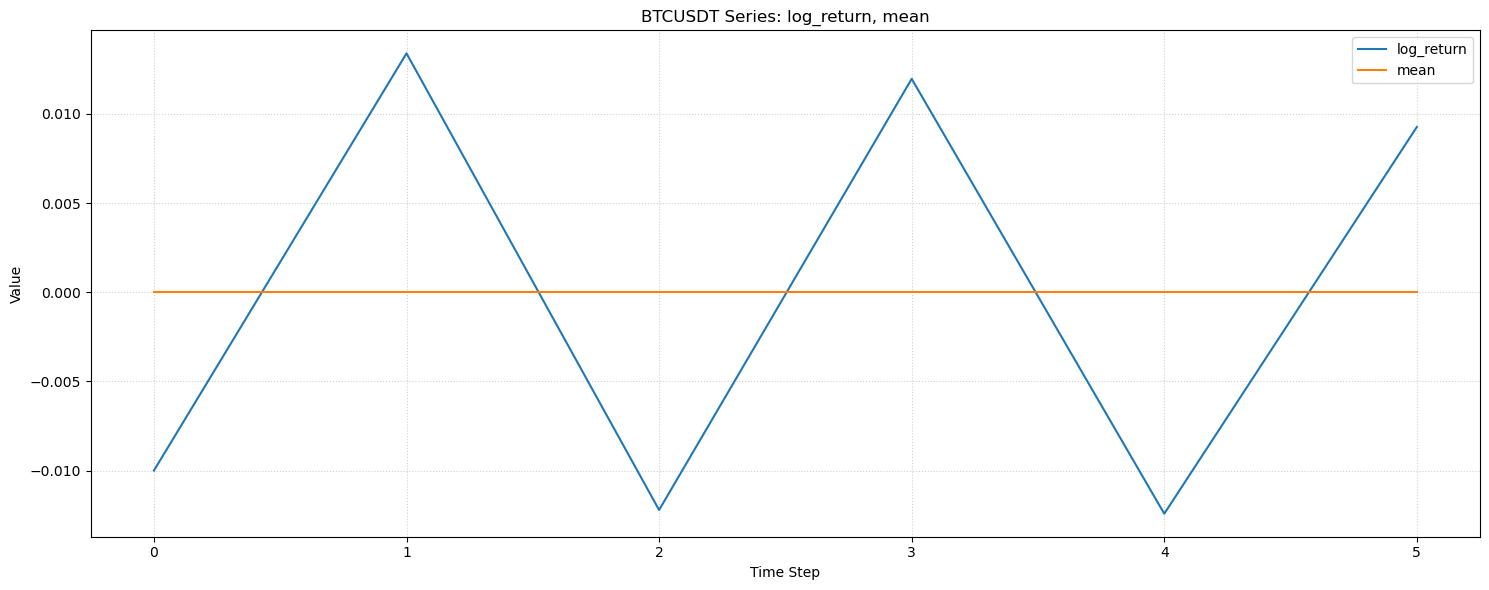

In [246]:
from typing import List

research.plot_multiple_lines(mean_reversion_df, ['log_return','mean'], sym)

### load time series data

In [254]:
ts = research.load_ohlc_timeseries(sym, time_interval)
ts

Loading BTCUSDT: 100%|██████████| 169/169 [00:08<00:00, 19.36file/s]


datetime,open,high,low,close
datetime[μs],f64,f64,f64,f64
2025-04-23 00:00:00,93404.9,94263.0,92552.0,94102.5
2025-04-23 08:00:00,94102.6,94904.3,91898.0,93140.3
2025-04-23 16:00:00,93140.3,94178.0,92860.0,93632.1
2025-04-24 00:00:00,93632.2,93735.1,92055.1,92166.0
2025-04-24 08:00:00,92166.1,93429.6,91619.0,93144.8
…,…,…,…,…
2025-10-07 08:00:00,123627.1,125098.0,121102.0,121788.3
2025-10-07 16:00:00,121788.2,122255.4,120516.0,121286.5
2025-10-08 00:00:00,121286.6,122196.9,121005.3,121550.4


### add log return target and it's lags

In [255]:
ts = research.add_log_return_features(ts, 'close', forecast_horizon, max_no_lags=1)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1
datetime[μs],f64,f64,f64,f64,f64,f64
2025-04-23 00:00:00,93404.9,94263.0,92552.0,94102.5,null,null
2025-04-23 08:00:00,94102.6,94904.3,91898.0,93140.3,-0.010278,null
2025-04-23 16:00:00,93140.3,94178.0,92860.0,93632.1,0.005266,-0.010278
2025-04-24 00:00:00,93632.2,93735.1,92055.1,92166.0,-0.015782,0.005266
2025-04-24 08:00:00,92166.1,93429.6,91619.0,93144.8,0.010564,-0.015782
…,…,…,…,…,…,…
2025-10-07 08:00:00,123627.1,125098.0,121102.0,121788.3,-0.014985,-0.008068
2025-10-07 16:00:00,121788.2,122255.4,120516.0,121286.5,-0.004129,-0.014985
2025-10-08 00:00:00,121286.6,122196.9,121005.3,121550.4,0.002173,-0.004129


### time split the time series

In [251]:
train_trades, test_trades = research.timeseries_split(ts, test_size)
train_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1
datetime[μs],f64,f64,f64,f64,f64,f64
2025-04-23 00:00:00,93404.9,94263.0,92552.0,94102.5,null,null
2025-04-23 08:00:00,94102.6,94904.3,91898.0,93140.3,-0.010278,null
2025-04-23 16:00:00,93140.3,94178.0,92860.0,93632.1,0.005266,-0.010278
2025-04-24 00:00:00,93632.2,93735.1,92055.1,92166.0,-0.015782,0.005266
2025-04-24 08:00:00,92166.1,93429.6,91619.0,93144.8,0.010564,-0.015782
…,…,…,…,…,…,…
2025-08-26 00:00:00,110064.1,110508.5,108559.7,110244.2,0.001636,-0.018706
2025-08-26 08:00:00,110244.2,110817.5,109350.0,109624.6,-0.005636,0.001636
2025-08-26 16:00:00,109624.6,112330.0,109400.0,111709.9,0.018844,-0.005636


In [252]:
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1
datetime[μs],f64,f64,f64,f64,f64,f64
2025-08-27 16:00:00,111965.0,112550.0,110854.4,111194.9,-0.006903,0.011472
2025-08-28 00:00:00,111194.9,113318.2,110811.0,113079.2,0.016804,-0.006903
2025-08-28 08:00:00,113079.3,113429.0,112344.4,112633.1,-0.003953,0.016804
2025-08-28 16:00:00,112633.1,113153.1,111829.4,112507.3,-0.001118,-0.003953
2025-08-29 00:00:00,112507.3,112585.7,109850.0,109969.0,-0.02282,-0.001118
…,…,…,…,…,…,…
2025-10-07 08:00:00,123627.1,125098.0,121102.0,121788.3,-0.014985,-0.008068
2025-10-07 16:00:00,121788.2,122255.4,120516.0,121286.5,-0.004129,-0.014985
2025-10-08 00:00:00,121286.6,122196.9,121005.3,121550.4,0.002173,-0.004129


In [ ]:
model = 

In [253]:
research.print_model_params(model)

linear.weight:
[[-0.09911217]]
linear.bias:
[0.00059838]


### Timing

In [142]:
# 00:00 -> trade to create a BTCUSDT position based on our prediction
# 08:00 -> trade to close the existing BTCUSDT position, trade to enter a new position on the current log return (00:00 -> 08:00) prediction
# 16:00 -> trade to close the existing BTCUSDT pos, trade to enter a new position on the current log return (08:00 -> 16:00) prediction

In [160]:
X_train, X_test, y_train, y_test = research.timeseries_train_test_split(ts, ['close_log_return_lag_1'], 'close_log_return', test_size)

In [161]:
y_hat = model(X_test)


In [162]:
y_hat = y_hat.detach().numpy()
y_hat

array([[-5.38613240e-04],
       [ 1.28252141e-03],
       [-1.06709497e-03],
       [ 9.90153058e-04],
       [ 7.09140382e-04],
       [ 2.86008022e-03],
       [ 2.08266103e-03],
       [ 6.00209809e-04],
       [ 4.75677865e-04],
       [ 2.85273592e-04],
       [ 6.45665743e-04],
       [ 6.90465153e-04],
       [ 5.06021548e-04],
       [ 1.10068766e-03],
       [-4.78297530e-04],
       [ 1.19116018e-03],
       [ 1.89152604e-04],
       [-3.07188428e-04],
       [ 6.03438239e-05],
       [ 2.42879847e-04],
       [ 7.29055144e-04],
       [-4.02562844e-04],
       [ 1.04897842e-03],
       [ 1.70743768e-03],
       [ 1.47227920e-03],
       [-5.10504993e-04],
       [-1.37054478e-03],
       [ 2.57205125e-03],
       [ 6.51409733e-04],
       [ 4.50648367e-04],
       [ 1.00701477e-03],
       [ 7.68138096e-04],
       [ 8.18286790e-05],
       [ 9.35024000e-05],
       [ 7.76856032e-04],
       [ 4.55359754e-04],
       [-5.85967035e-04],
       [ 1.09353103e-03],
       [-2.2

In [164]:
y_hat = y_hat.squeeze()
y_hat

array([-5.38613240e-04,  1.28252141e-03, -1.06709497e-03,  9.90153058e-04,
        7.09140382e-04,  2.86008022e-03,  2.08266103e-03,  6.00209809e-04,
        4.75677865e-04,  2.85273592e-04,  6.45665743e-04,  6.90465153e-04,
        5.06021548e-04,  1.10068766e-03, -4.78297530e-04,  1.19116018e-03,
        1.89152604e-04, -3.07188428e-04,  6.03438239e-05,  2.42879847e-04,
        7.29055144e-04, -4.02562844e-04,  1.04897842e-03,  1.70743768e-03,
        1.47227920e-03, -5.10504993e-04, -1.37054478e-03,  2.57205125e-03,
        6.51409733e-04,  4.50648367e-04,  1.00701477e-03,  7.68138096e-04,
        8.18286790e-05,  9.35024000e-05,  7.76856032e-04,  4.55359754e-04,
       -5.85967035e-04,  1.09353103e-03, -2.27696437e-04,  2.47633061e-03,
        1.19989272e-06, -2.86732917e-04, -5.41393470e-04,  5.15241758e-04,
        4.73846711e-04,  5.26878925e-04, -5.28288947e-04,  9.23484913e-04,
        5.84683497e-04, -1.85364217e-04,  8.23302660e-04,  5.93412376e-04,
        4.77348687e-04,  

In [165]:
test_trades = test_trades.with_columns(pl.Series('prediction', y_hat))
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,prediction
datetime[μs],f64,f64,f64,f64,f64,f64,f32
2025-08-27 16:00:00,111965.0,112550.0,110854.4,111194.9,-0.006903,0.011472,-0.000539
2025-08-28 00:00:00,111194.9,113318.2,110811.0,113079.2,0.016804,-0.006903,0.001283
2025-08-28 08:00:00,113079.3,113429.0,112344.4,112633.1,-0.003953,0.016804,-0.001067
2025-08-28 16:00:00,112633.1,113153.1,111829.4,112507.3,-0.001118,-0.003953,0.00099
2025-08-29 00:00:00,112507.3,112585.7,109850.0,109969.0,-0.02282,-0.001118,0.000709
…,…,…,…,…,…,…,…
2025-10-07 08:00:00,123627.1,125098.0,121102.0,121788.3,-0.014985,-0.008068,0.001398
2025-10-07 16:00:00,121788.2,122255.4,120516.0,121286.5,-0.004129,-0.014985,0.002084
2025-10-08 00:00:00,121286.6,122196.9,121005.3,121550.4,0.002173,-0.004129,0.001008


In [166]:
0.003599 * -0.04842816 

-0.00017429294784

In [167]:
0.003599 * -0.04842816 + 0.00031457 

0.00014027705216000002

### directional signal

In [168]:
test_trades = test_trades.with_columns(pl.col('prediction').sign().alias('dir_signal'))
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,prediction,dir_signal
datetime[μs],f64,f64,f64,f64,f64,f64,f32,f32
2025-08-27 16:00:00,111965.0,112550.0,110854.4,111194.9,-0.006903,0.011472,-0.000539,-1.0
2025-08-28 00:00:00,111194.9,113318.2,110811.0,113079.2,0.016804,-0.006903,0.001283,1.0
2025-08-28 08:00:00,113079.3,113429.0,112344.4,112633.1,-0.003953,0.016804,-0.001067,-1.0
2025-08-28 16:00:00,112633.1,113153.1,111829.4,112507.3,-0.001118,-0.003953,0.00099,1.0
2025-08-29 00:00:00,112507.3,112585.7,109850.0,109969.0,-0.02282,-0.001118,0.000709,1.0
…,…,…,…,…,…,…,…,…
2025-10-07 08:00:00,123627.1,125098.0,121102.0,121788.3,-0.014985,-0.008068,0.001398,1.0
2025-10-07 16:00:00,121788.2,122255.4,120516.0,121286.5,-0.004129,-0.014985,0.002084,1.0
2025-10-08 00:00:00,121286.6,122196.9,121005.3,121550.4,0.002173,-0.004129,0.001008,1.0


### calculate each trade's log return 

In [169]:
test_trades = test_trades.with_columns((pl.col('close_log_return')*pl.col('dir_signal')).alias('trade_log_return'))
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,prediction,dir_signal,trade_log_return
datetime[μs],f64,f64,f64,f64,f64,f64,f32,f32,f64
2025-08-27 16:00:00,111965.0,112550.0,110854.4,111194.9,-0.006903,0.011472,-0.000539,-1.0,0.006903
2025-08-28 00:00:00,111194.9,113318.2,110811.0,113079.2,0.016804,-0.006903,0.001283,1.0,0.016804
2025-08-28 08:00:00,113079.3,113429.0,112344.4,112633.1,-0.003953,0.016804,-0.001067,-1.0,0.003953
2025-08-28 16:00:00,112633.1,113153.1,111829.4,112507.3,-0.001118,-0.003953,0.00099,1.0,-0.001118
2025-08-29 00:00:00,112507.3,112585.7,109850.0,109969.0,-0.02282,-0.001118,0.000709,1.0,-0.02282
…,…,…,…,…,…,…,…,…,…
2025-10-07 08:00:00,123627.1,125098.0,121102.0,121788.3,-0.014985,-0.008068,0.001398,1.0,-0.014985
2025-10-07 16:00:00,121788.2,122255.4,120516.0,121286.5,-0.004129,-0.014985,0.002084,1.0,-0.004129
2025-10-08 00:00:00,121286.6,122196.9,121005.3,121550.4,0.002173,-0.004129,0.001008,1.0,0.002173


### calculate each trade's compounded log return

In [174]:
test_trades = test_trades.with_columns(pl.col('trade_log_return').cum_sum().alias('cum_trade_log_return'))
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,prediction,dir_signal,trade_log_return,trade_value,trade_size,signed_trade_size,cum_trade_log_return
datetime[μs],f64,f64,f64,f64,f64,f64,f32,f32,f64,i32,f64,f64,f64
2025-08-27 16:00:00,111965.0,112550.0,110854.4,111194.9,-0.006903,0.011472,-0.000539,-1.0,0.006903,100,0.000893,-0.000893,0.006903
2025-08-28 00:00:00,111194.9,113318.2,110811.0,113079.2,0.016804,-0.006903,0.001283,1.0,0.016804,100,0.000899,0.000899,0.023707
2025-08-28 08:00:00,113079.3,113429.0,112344.4,112633.1,-0.003953,0.016804,-0.001067,-1.0,0.003953,100,0.000884,-0.000884,0.027659
2025-08-28 16:00:00,112633.1,113153.1,111829.4,112507.3,-0.001118,-0.003953,0.00099,1.0,-0.001118,100,0.000888,0.000888,0.026542
2025-08-29 00:00:00,112507.3,112585.7,109850.0,109969.0,-0.02282,-0.001118,0.000709,1.0,-0.02282,100,0.000889,0.000889,0.003722
…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-10-07 08:00:00,123627.1,125098.0,121102.0,121788.3,-0.014985,-0.008068,0.001398,1.0,-0.014985,100,0.000809,0.000809,0.141796
2025-10-07 16:00:00,121788.2,122255.4,120516.0,121286.5,-0.004129,-0.014985,0.002084,1.0,-0.004129,100,0.000821,0.000821,0.137667
2025-10-08 00:00:00,121286.6,122196.9,121005.3,121550.4,0.002173,-0.004129,0.001008,1.0,0.002173,100,0.000824,0.000824,0.139841


### constant trade size

In [ ]:
view_cols = [
    'datetime',
    'close_log_return',
    'close_log_return_lag_1',
    'prediction',
    'dir_signal',
    'trade_log_return',
    'cum_trade_log_return',
    'trade_value',
    'trade_size',
    'signed_trade_size'
]

In [182]:
capital = 100
trade_value = capital
test_trades = test_trades.with_columns(
    pl.lit(trade_value).alias('trade_value'),
    (trade_value / pl.col('open')).alias('trade_size')
).with_columns((pl.col('trade_size') *pl.col('dir_signal')).alias('signed_trade_size'))

test_trades.select(view_cols)

datetime,close_log_return,close_log_return_lag_1,prediction,dir_signal,trade_log_return,cum_trade_log_return,trade_value,trade_size,signed_trade_size
datetime[μs],f64,f64,f32,f32,f64,f64,i32,f64,f64
2025-08-27 16:00:00,-0.006903,0.011472,-0.000539,-1.0,0.006903,0.006903,100,0.000893,-0.000893
2025-08-28 00:00:00,0.016804,-0.006903,0.001283,1.0,0.016804,0.023707,100,0.000899,0.000899
2025-08-28 08:00:00,-0.003953,0.016804,-0.001067,-1.0,0.003953,0.027659,100,0.000884,-0.000884
2025-08-28 16:00:00,-0.001118,-0.003953,0.00099,1.0,-0.001118,0.026542,100,0.000888,0.000888
2025-08-29 00:00:00,-0.02282,-0.001118,0.000709,1.0,-0.02282,0.003722,100,0.000889,0.000889
…,…,…,…,…,…,…,…,…,…
2025-10-07 08:00:00,-0.014985,-0.008068,0.001398,1.0,-0.014985,0.141796,100,0.000809,0.000809
2025-10-07 16:00:00,-0.004129,-0.014985,0.002084,1.0,-0.004129,0.137667,100,0.000821,0.000821
2025-10-08 00:00:00,0.002173,-0.004129,0.001008,1.0,0.002173,0.139841,100,0.000824,0.000824


### add individual trade pnl

In [186]:
test_trades = test_trades.with_columns(((pl.col('trade_log_return').exp() - 1) * pl.col('trade_value')).alias('trade_gross_pnl'))
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,prediction,dir_signal,trade_log_return,trade_value,trade_size,signed_trade_size,cum_trade_log_return,trade_gross_pnl
datetime[μs],f64,f64,f64,f64,f64,f64,f32,f32,f64,i32,f64,f64,f64,f64
2025-08-27 16:00:00,111965.0,112550.0,110854.4,111194.9,-0.006903,0.011472,-0.000539,-1.0,0.006903,100,0.000893,-0.000893,0.006903,0.692658
2025-08-28 00:00:00,111194.9,113318.2,110811.0,113079.2,0.016804,-0.006903,0.001283,1.0,0.016804,100,0.000899,0.000899,0.023707,1.694592
2025-08-28 08:00:00,113079.3,113429.0,112344.4,112633.1,-0.003953,0.016804,-0.001067,-1.0,0.003953,100,0.000884,-0.000884,0.027659,0.396065
2025-08-28 16:00:00,112633.1,113153.1,111829.4,112507.3,-0.001118,-0.003953,0.00099,1.0,-0.001118,100,0.000888,0.000888,0.026542,-0.11169
2025-08-29 00:00:00,112507.3,112585.7,109850.0,109969.0,-0.02282,-0.001118,0.000709,1.0,-0.02282,100,0.000889,0.000889,0.003722,-2.25612
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-10-07 08:00:00,123627.1,125098.0,121102.0,121788.3,-0.014985,-0.008068,0.001398,1.0,-0.014985,100,0.000809,0.000809,0.141796,-1.487376
2025-10-07 16:00:00,121788.2,122255.4,120516.0,121286.5,-0.004129,-0.014985,0.002084,1.0,-0.004129,100,0.000821,0.000821,0.137667,-0.412026
2025-10-08 00:00:00,121286.6,122196.9,121005.3,121550.4,0.002173,-0.004129,0.001008,1.0,0.002173,100,0.000824,0.000824,0.139841,0.217584


#### cumulate gross trade pnl

In [115]:
test_trades = train_trades.wi

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,prediction,dir_signal,trade_value,trade_size,signed_trade_size,trade_log_return,trade_gross_pnl
datetime[μs],f64,f64,f64,f64,f64,f64,f32,f32,i32,f64,f64,f64,f64
2025-08-27 16:00:00,111965.0,112550.0,110854.4,111194.9,-0.006903,0.011472,-0.000539,-1.0,100,0.000893,-0.000893,0.006903,0.692658
2025-08-28 00:00:00,111194.9,113318.2,110811.0,113079.2,0.016804,-0.006903,0.001283,1.0,100,0.000899,0.000899,0.016804,1.694592
2025-08-28 08:00:00,113079.3,113429.0,112344.4,112633.1,-0.003953,0.016804,-0.001067,-1.0,100,0.000884,-0.000884,0.003953,0.396065
2025-08-28 16:00:00,112633.1,113153.1,111829.4,112507.3,-0.001118,-0.003953,0.00099,1.0,100,0.000888,0.000888,-0.001118,-0.11169
2025-08-29 00:00:00,112507.3,112585.7,109850.0,109969.0,-0.02282,-0.001118,0.000709,1.0,100,0.000889,0.000889,-0.02282,-2.25612
…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-10-07 08:00:00,123627.1,125098.0,121102.0,121788.3,-0.014985,-0.008068,0.001398,1.0,100,0.000809,0.000809,-0.014985,-1.487376
2025-10-07 16:00:00,121788.2,122255.4,120516.0,121286.5,-0.004129,-0.014985,0.002084,1.0,100,0.000821,0.000821,-0.004129,-0.412026
2025-10-08 00:00:00,121286.6,122196.9,121005.3,121550.4,0.002173,-0.004129,0.001008,1.0,100,0.000824,0.000824,0.002173,0.217584


In [116]:
test_trades['trade_gross_pnl'].mean()

0.1246874302516153

In [117]:
test_trades = test_trades.with_columns(pl.col('trade_gross_pnl').cum_sum().alias('cum_trade_gross_pnl'))
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,prediction,dir_signal,trade_value,trade_size,signed_trade_size,trade_log_return,trade_gross_pnl,cum_trade_gross_pnl
datetime[μs],f64,f64,f64,f64,f64,f64,f32,f32,i32,f64,f64,f64,f64,f64
2025-08-27 16:00:00,111965.0,112550.0,110854.4,111194.9,-0.006903,0.011472,-0.000539,-1.0,100,0.000893,-0.000893,0.006903,0.692658,0.692658
2025-08-28 00:00:00,111194.9,113318.2,110811.0,113079.2,0.016804,-0.006903,0.001283,1.0,100,0.000899,0.000899,0.016804,1.694592,2.38725
2025-08-28 08:00:00,113079.3,113429.0,112344.4,112633.1,-0.003953,0.016804,-0.001067,-1.0,100,0.000884,-0.000884,0.003953,0.396065,2.783315
2025-08-28 16:00:00,112633.1,113153.1,111829.4,112507.3,-0.001118,-0.003953,0.00099,1.0,100,0.000888,0.000888,-0.001118,-0.11169,2.671624
2025-08-29 00:00:00,112507.3,112585.7,109850.0,109969.0,-0.02282,-0.001118,0.000709,1.0,100,0.000889,0.000889,-0.02282,-2.25612,0.415504
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-10-07 08:00:00,123627.1,125098.0,121102.0,121788.3,-0.014985,-0.008068,0.001398,1.0,100,0.000809,0.000809,-0.014985,-1.487376,14.646121
2025-10-07 16:00:00,121788.2,122255.4,120516.0,121286.5,-0.004129,-0.014985,0.002084,1.0,100,0.000821,0.000821,-0.004129,-0.412026,14.234095
2025-10-08 00:00:00,121286.6,122196.9,121005.3,121550.4,0.002173,-0.004129,0.001008,1.0,100,0.000824,0.000824,0.002173,0.217584,14.451679


In [118]:
constant_trade_size_ret = 1 + test_trades['cum_trade_gross_pnl'][-1] / trade_value
constant_trade_size_ret

1.1583530364195513

## trade-by-trade compounding

In [119]:
test_trades = test_trades.with_columns(pl.col('trade_log_return').cum_sum().alias('cum_trade_log_return'))
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,prediction,dir_signal,trade_value,trade_size,signed_trade_size,trade_log_return,trade_gross_pnl,cum_trade_gross_pnl,cum_trade_log_return
datetime[μs],f64,f64,f64,f64,f64,f64,f32,f32,i32,f64,f64,f64,f64,f64,f64
2025-08-27 16:00:00,111965.0,112550.0,110854.4,111194.9,-0.006903,0.011472,-0.000539,-1.0,100,0.000893,-0.000893,0.006903,0.692658,0.692658,0.006903
2025-08-28 00:00:00,111194.9,113318.2,110811.0,113079.2,0.016804,-0.006903,0.001283,1.0,100,0.000899,0.000899,0.016804,1.694592,2.38725,0.023707
2025-08-28 08:00:00,113079.3,113429.0,112344.4,112633.1,-0.003953,0.016804,-0.001067,-1.0,100,0.000884,-0.000884,0.003953,0.396065,2.783315,0.027659
2025-08-28 16:00:00,112633.1,113153.1,111829.4,112507.3,-0.001118,-0.003953,0.00099,1.0,100,0.000888,0.000888,-0.001118,-0.11169,2.671624,0.026542
2025-08-29 00:00:00,112507.3,112585.7,109850.0,109969.0,-0.02282,-0.001118,0.000709,1.0,100,0.000889,0.000889,-0.02282,-2.25612,0.415504,0.003722
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-10-07 08:00:00,123627.1,125098.0,121102.0,121788.3,-0.014985,-0.008068,0.001398,1.0,100,0.000809,0.000809,-0.014985,-1.487376,14.646121,0.141796
2025-10-07 16:00:00,121788.2,122255.4,120516.0,121286.5,-0.004129,-0.014985,0.002084,1.0,100,0.000821,0.000821,-0.004129,-0.412026,14.234095,0.137667
2025-10-08 00:00:00,121286.6,122196.9,121005.3,121550.4,0.002173,-0.004129,0.001008,1.0,100,0.000824,0.000824,0.002173,0.217584,14.451679,0.139841


In [120]:
test_trades = test_trades.with_columns((pl.col('cum_trade_log_return').exp()*trade_value).alias('compound_trade_pnl'))
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,prediction,dir_signal,trade_value,trade_size,signed_trade_size,trade_log_return,trade_gross_pnl,cum_trade_gross_pnl,cum_trade_log_return,compound_trade_pnl
datetime[μs],f64,f64,f64,f64,f64,f64,f32,f32,i32,f64,f64,f64,f64,f64,f64,f64
2025-08-27 16:00:00,111965.0,112550.0,110854.4,111194.9,-0.006903,0.011472,-0.000539,-1.0,100,0.000893,-0.000893,0.006903,0.692658,0.692658,0.006903,100.692658
2025-08-28 00:00:00,111194.9,113318.2,110811.0,113079.2,0.016804,-0.006903,0.001283,1.0,100,0.000899,0.000899,0.016804,1.694592,2.38725,0.023707,102.398987
2025-08-28 08:00:00,113079.3,113429.0,112344.4,112633.1,-0.003953,0.016804,-0.001067,-1.0,100,0.000884,-0.000884,0.003953,0.396065,2.783315,0.027659,102.804554
2025-08-28 16:00:00,112633.1,113153.1,111829.4,112507.3,-0.001118,-0.003953,0.00099,1.0,100,0.000888,0.000888,-0.001118,-0.11169,2.671624,0.026542,102.689731
2025-08-29 00:00:00,112507.3,112585.7,109850.0,109969.0,-0.02282,-0.001118,0.000709,1.0,100,0.000889,0.000889,-0.02282,-2.25612,0.415504,0.003722,100.372927
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-10-07 08:00:00,123627.1,125098.0,121102.0,121788.3,-0.014985,-0.008068,0.001398,1.0,100,0.000809,0.000809,-0.014985,-1.487376,14.646121,0.141796,115.234157
2025-10-07 16:00:00,121788.2,122255.4,120516.0,121286.5,-0.004129,-0.014985,0.002084,1.0,100,0.000821,0.000821,-0.004129,-0.412026,14.234095,0.137667,114.759362
2025-10-08 00:00:00,121286.6,122196.9,121005.3,121550.4,0.002173,-0.004129,0.001008,1.0,100,0.000824,0.000824,0.002173,0.217584,14.451679,0.139841,115.00906


In [121]:
(test_trades['compound_trade_pnl'][-1])/trade_value

1.1660536700290123

In [122]:
# display equity curve
research.plot_dyn_timeseries(test_trades, 'Equity Curve', 'compound_trade_pnl', time_interval)


alt.Chart(...)

## Add Leverage

In [123]:
test_trades = test_trades.drop('trade_value','cum_trade_gross_pnl', 'trade_value', 'trade_size','signed_trade_size','trade_gross_pnl','compound_trade_pnl', strict=False)
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,prediction,dir_signal,trade_log_return,cum_trade_log_return
datetime[μs],f64,f64,f64,f64,f64,f64,f32,f32,f64,f64
2025-08-27 16:00:00,111965.0,112550.0,110854.4,111194.9,-0.006903,0.011472,-0.000539,-1.0,0.006903,0.006903
2025-08-28 00:00:00,111194.9,113318.2,110811.0,113079.2,0.016804,-0.006903,0.001283,1.0,0.016804,0.023707
2025-08-28 08:00:00,113079.3,113429.0,112344.4,112633.1,-0.003953,0.016804,-0.001067,-1.0,0.003953,0.027659
2025-08-28 16:00:00,112633.1,113153.1,111829.4,112507.3,-0.001118,-0.003953,0.00099,1.0,-0.001118,0.026542
2025-08-29 00:00:00,112507.3,112585.7,109850.0,109969.0,-0.02282,-0.001118,0.000709,1.0,-0.02282,0.003722
…,…,…,…,…,…,…,…,…,…,…
2025-10-07 08:00:00,123627.1,125098.0,121102.0,121788.3,-0.014985,-0.008068,0.001398,1.0,-0.014985,0.141796
2025-10-07 16:00:00,121788.2,122255.4,120516.0,121286.5,-0.004129,-0.014985,0.002084,1.0,-0.004129,0.137667
2025-10-08 00:00:00,121286.6,122196.9,121005.3,121550.4,0.002173,-0.004129,0.001008,1.0,0.002173,0.139841


In [124]:
inital_capital = 1000
leverage_ratio = 8
leveraged_capital = inital_capital * leverage_ratio
leveraged_capital

8000

In [125]:
test_trades = test_trades.with_columns(
    (((pl.col('cum_trade_log_return').exp() - 1) * leveraged_capital)).alias('cum_trade_gross_pnl'),
)
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,prediction,dir_signal,trade_log_return,cum_trade_log_return,cum_trade_gross_pnl
datetime[μs],f64,f64,f64,f64,f64,f64,f32,f32,f64,f64,f64
2025-08-27 16:00:00,111965.0,112550.0,110854.4,111194.9,-0.006903,0.011472,-0.000539,-1.0,0.006903,0.006903,55.412613
2025-08-28 00:00:00,111194.9,113318.2,110811.0,113079.2,0.016804,-0.006903,0.001283,1.0,0.016804,0.023707,191.919
2025-08-28 08:00:00,113079.3,113429.0,112344.4,112633.1,-0.003953,0.016804,-0.001067,-1.0,0.003953,0.027659,224.364303
2025-08-28 16:00:00,112633.1,113153.1,111829.4,112507.3,-0.001118,-0.003953,0.00099,1.0,-0.001118,0.026542,215.178504
2025-08-29 00:00:00,112507.3,112585.7,109850.0,109969.0,-0.02282,-0.001118,0.000709,1.0,-0.02282,0.003722,29.834196
…,…,…,…,…,…,…,…,…,…,…,…
2025-10-07 08:00:00,123627.1,125098.0,121102.0,121788.3,-0.014985,-0.008068,0.001398,1.0,-0.014985,0.141796,1218.732557
2025-10-07 16:00:00,121788.2,122255.4,120516.0,121286.5,-0.004129,-0.014985,0.002084,1.0,-0.004129,0.137667,1180.748941
2025-10-08 00:00:00,121286.6,122196.9,121005.3,121550.4,0.002173,-0.004129,0.001008,1.0,0.002173,0.139841,1200.72478


In [126]:
total_pnl = test_trades['cum_trade_gross_pnl'][-1]
total_pnl

1328.4293602320981

In [127]:
total_pnl/inital_capital

1.3284293602320982

In [128]:
days_between = (
    (test_trades['datetime'][-1] - test_trades['datetime'][0])
    .total_seconds() / 86400
)
# 30% of a year
f"{test_trades['datetime'][0]} to {test_trades['datetime'][-1]}: {days_between:.1f} days"

'2025-08-27 16:00:00 to 2025-10-08 16:00:00: 42.0 days'

## Risk Management

In [129]:
test_trades = test_trades.with_columns((inital_capital+pl.col('compound_trade_gross_pnl')).alias('equity_curve'))

ColumnNotFoundError: unable to find column "compound_trade_gross_pnl"; valid columns: ["datetime", "open", "high", "low", "close", "close_log_return", "close_log_return_lag_1", "prediction", "dir_signal", "trade_log_return", "cum_trade_log_return", "cum_trade_gross_pnl"]

In [ ]:
research.plot_column(test_trades, 'equity_curve')

### liquidation rate (working at the worst drawdown we can tolerate before being liquidated)

In [ ]:
def liquidation_price(entry_price: float, leverage: float, dir_signal: int, maintenance_margin: float = 0.005):
    """
    Calculate liquidation price for margin trading.
    
    dir_signal:  1 for long, -1 for short
    maintenance_margin: e.g. 0.005 for 0.5%
    """
    if dir_signal == 1:  # long
        return entry_price * (1 - 1/leverage + maintenance_margin)
    elif dir_signal == -1:  # short
        return entry_price * (1 + 1/leverage - maintenance_margin)
    else:
        raise ValueError("dir_signal must be 1 (long) or -1 (short)")


liquidation_price(111710.0, 20, 1)

In [ ]:
maintainance_margin = 0.005 # 0.5%
liquidation_price(111710.0, 20, 1, maintainance_margin)

In [ ]:
liquidation_price(111710.0, 8, 1, maintainance_margin)

In [ ]:
liquidation_price(111710.0, 2, 1, maintainance_margin)

In [ ]:
test_trades

In [ ]:

LEVERAGE = 2
MAINT_MARGIN = 0.005  # 0.5%

test_trades.with_columns(
    pl.when(pl.col("dir_signal") == 1)
      .then(pl.col("open") * (1 - 1/LEVERAGE + MAINT_MARGIN))
      .otherwise(pl.col("open") * (1 + 1/LEVERAGE - MAINT_MARGIN))
      .alias("liq_price")
)

### intraperiod drawdown intensity (how deep did the trade go underwater)

In [ ]:
test_trades = test_trades.with_columns(
    (pl.col("low") / pl.col("open")).log().alias("log_drawdown_from_open")
)
test_trades

In [ ]:
initial_margin_rate = 1 / leverage_ratio
initial_margin_rate

In [ ]:
test_trades.with_columns((pl.col('open')*initial_margin_rate).alias('imr'))

In [ ]:
# topics we haven't covered
# alpha decay (also known as model drift) => where the performance drifts => 
# market impact => we are not trading big sizes => if we were, we could potentially move markets against us
# slippage => we may not always get the best price, we may get executed at prices below top of the book (best bid/ask)
# spread => BTCUSDT has quite tight spreads => so we have nominal spread costs